In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Step 1: Generate Synthetic Dataset
def generate_customer_data(num_customers=300):
    """Generate synthetic customer data matching the project requirements"""
    np.random.seed(42)
    
    # Generate random ages between 18 and 70
    ages = np.random.randint(18, 70, size=num_customers)
    
    # Generate annual income (skewed towards lower incomes)
    income = np.random.gamma(shape=2, scale=25000, size=num_customers).astype(int)
    
    # Generate spending scores (0-100)
    spending = np.random.beta(a=2, b=5, size=num_customers) * 100
    spending = spending.astype(int)
    
    # Create DataFrame
    data = {
        'Customer_ID': [f'CUST_{i:03d}' for i in range(1, num_customers+1)],
        'Age': ages,
        'Annual_Income': income,
        'Spending_Score': spending
    }
    
    df = pd.DataFrame(data)
    return df

In [3]:
# Step 2: Data Preprocessing
def preprocess_data(df):
    """Preprocess the data for clustering"""
    # Make a copy of the original data
    df_processed = df.copy()
    
    # Drop Customer ID as it's not useful for clustering
    df_processed = df_processed.drop('Customer_ID', axis=1)
    
    # Check for missing values
    print("\n=== Missing Values ===")
    print(df_processed.isnull().sum())
    
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_processed)
    df_scaled = pd.DataFrame(scaled_data, columns=df_processed.columns)
    
    return df_scaled, scaler

In [4]:
# Step 3: Determine Optimal Number of Clusters
def find_optimal_clusters(data):
    """Find the optimal number of clusters using Elbow Method and Silhouette Score"""
    wcss = []
    silhouette_scores = []
    cluster_range = range(2, 11)
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
        if len(np.unique(kmeans.labels_)) >= 2:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(data, kmeans.labels_)
            silhouette_scores.append(score)
    
    # Plot Elbow Method
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cluster_range, wcss, 'bo-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')
    
    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(cluster_range, silhouette_scores, 'go-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal number of clusters (elbow point)
    optimal_clusters = 5  # Default, you can implement automatic detection if needed
    print(f"\nSuggested optimal number of clusters: {optimal_clusters}")
    
    return optimal_clusters

In [5]:
# Step 4: Apply K-Means Clustering
def apply_kmeans(data, n_clusters):
    """Apply K-Means clustering and return labels"""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    return clusters, kmeans

In [6]:
# Step 5: Visualization
def visualize_clusters(df, original_df, clusters, kmeans):
    """Create visualizations of the clusters"""
    # Reduce dimensions for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(df)
    
    # Create a DataFrame for visualization
    viz_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    viz_df['Cluster'] = clusters
    viz_df['Age'] = original_df['Age']
    viz_df['Annual_Income'] = original_df['Annual_Income']
    viz_df['Spending_Score'] = original_df['Spending_Score']
    
    # 2D Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=viz_df, palette='viridis', s=100)
    plt.title('Customer Segments (PCA Reduced)')
    plt.show()
    
    # Pair Plots
    plt.figure(figsize=(12, 8))
    sns.pairplot(viz_df, hue='Cluster', palette='viridis', 
                vars=['Age', 'Annual_Income', 'Spending_Score'])
    plt.suptitle('Pair Plots by Cluster', y=1.02)
    plt.show()
    
    # Cluster Centroids
    centroids = kmeans.cluster_centers_
    centroids = pd.DataFrame(scaler.inverse_transform(centroids), 
                            columns=['Age', 'Annual_Income', 'Spending_Score'])
    centroids['Cluster'] = range(len(centroids))
    
    print("\n=== Cluster Centroids ===")
    print(centroids)
    
    # Plot centroids
    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(['Age', 'Annual_Income', 'Spending_Score']):
        plt.subplot(1, 3, i+1)
        sns.barplot(x='Cluster', y=feature, data=centroids)
        plt.title(f'Average {feature} by Cluster')
    plt.tight_layout()
    plt.show()

In [7]:
# Step 6: Generate Business Recommendations
def generate_recommendations(df, clusters):
    """Generate business recommendations based on clusters"""
    # Add cluster labels to original data
    clustered_df = df.copy()
    clustered_df['Cluster'] = clusters
    
    # Calculate cluster statistics
    cluster_stats = clustered_df.groupby('Cluster').agg({
        'Age': ['mean', 'median'],
        'Annual_Income': ['mean', 'median'],
        'Spending_Score': ['mean', 'median', 'count']
    })
    
    print("\n=== Cluster Statistics ===")
    print(cluster_stats)
    
    print("\n=== Business Recommendations ===")
    print("1. High Income, High Spending (Premium Customers):")
    print("   - Target with exclusive offers and loyalty programs")
    print("   - Offer premium products and personalized services")
    
    print("\n2. High Income, Low Spending:")
    print("   - Focus on converting to higher spending with targeted promotions")
    print("   - Understand why they're not spending (maybe product mismatch)")
    
    print("\n3. Low Income, High Spending:")
    print("   - Monitor for financial risk (potential overspending)")
    print("   - Offer budget-friendly options to maintain engagement")
    
    print("\n4. Low Income, Low Spending:")
    print("   - Focus on value-oriented marketing")
    print("   - Consider whether to prioritize this segment based on profitability")
    
    print("\n5. Middle Income, Middle Spending:")
    print("   - Largest potential for growth")
    print("   - Focus on upselling and cross-selling opportunities")

Generating synthetic customer data...

Preprocessing data...

=== Missing Values ===
Age               0
Annual_Income     0
Spending_Score    0
dtype: int64

Finding optimal number of clusters...


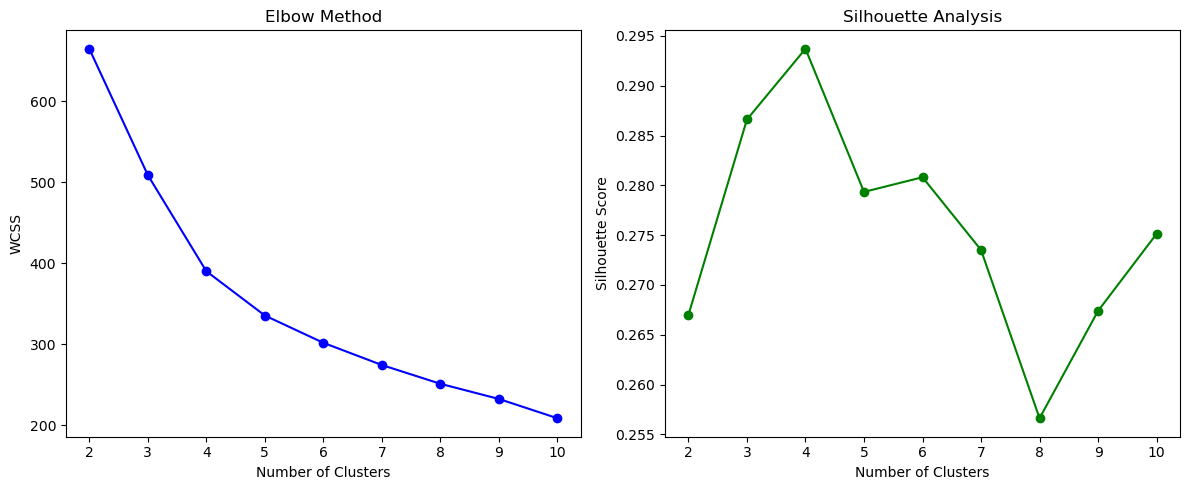


Suggested optimal number of clusters: 5

Applying K-Means clustering...

Visualizing clusters...


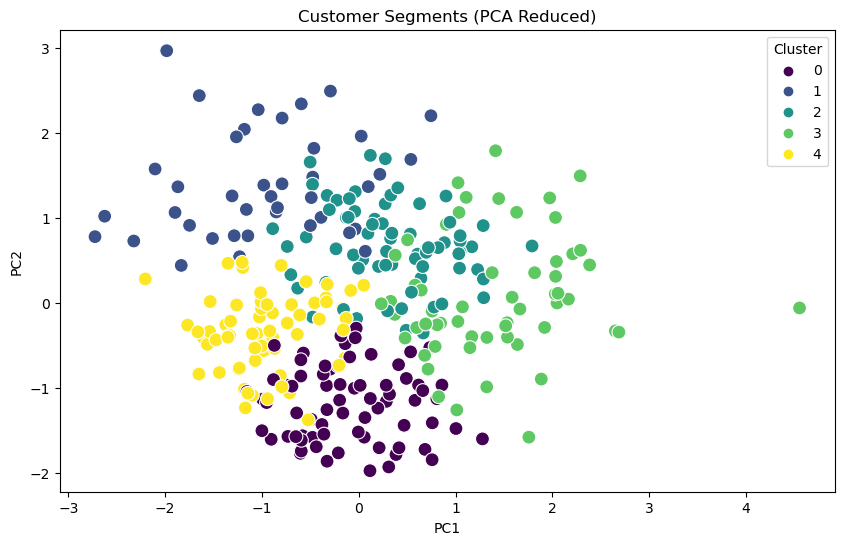

<Figure size 1200x800 with 0 Axes>

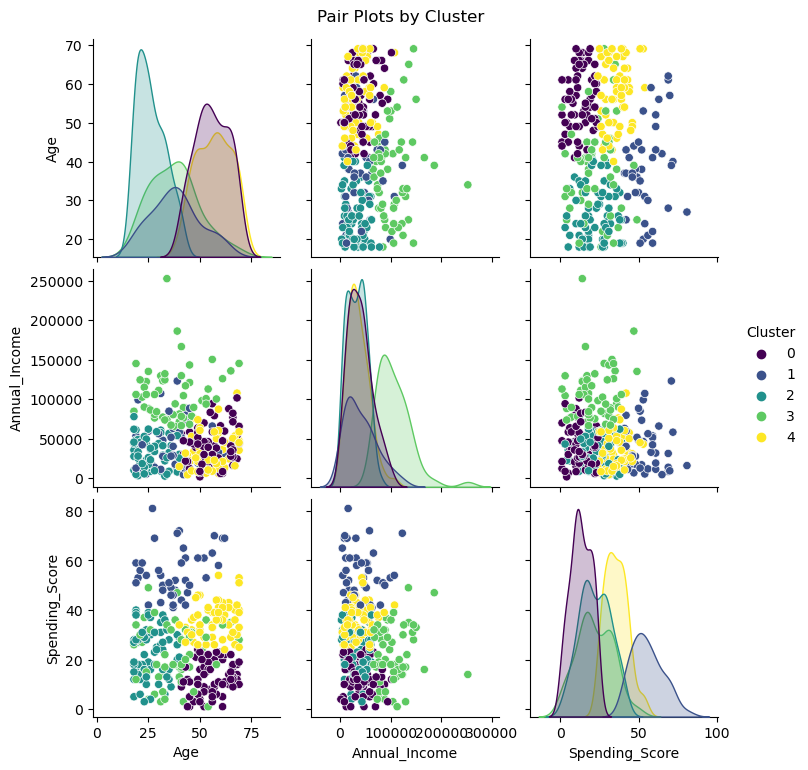


=== Cluster Centroids ===
         Age  Annual_Income  Spending_Score  Cluster
0  55.704225   39402.309859       12.929577        0
1  38.125000   41589.450000       55.425000        1
2  26.333333   32426.231884       22.144928        2
3  37.603448  106011.620690       22.000000        3
4  56.741935   35852.112903       35.580645        4


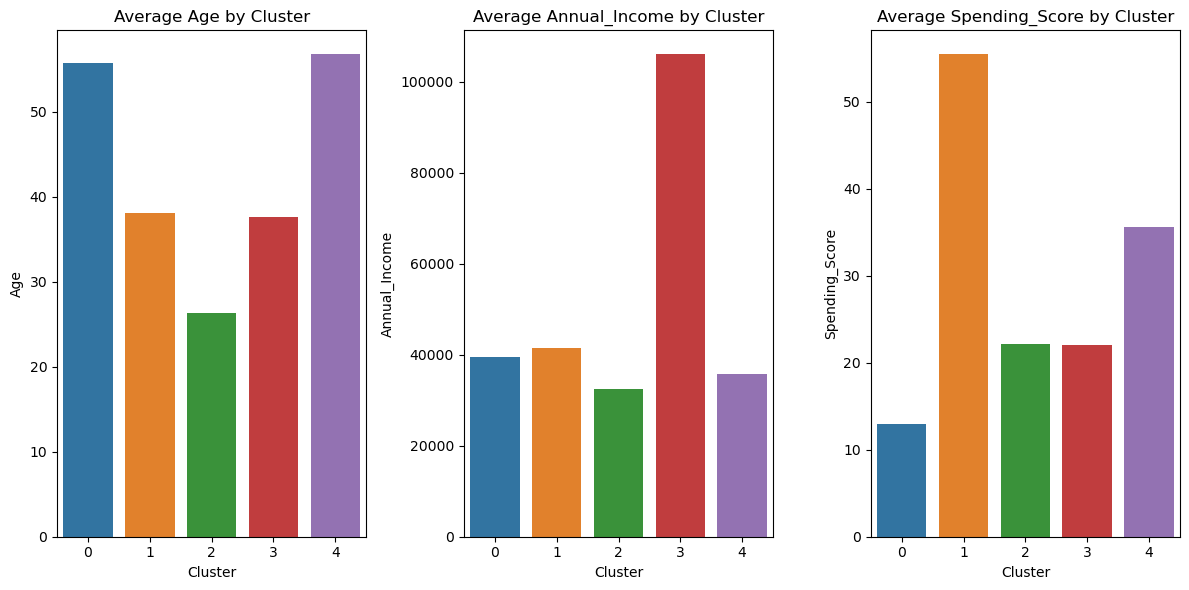


Generating business recommendations...

=== Cluster Statistics ===
               Age         Annual_Income           Spending_Score             
              mean median           mean    median           mean median count
Cluster                                                                       
0        55.704225   56.0   39402.309859   38277.0      12.929577   12.0    71
1        38.125000   37.5   41589.450000   32570.0      55.425000   53.5    40
2        26.333333   25.0   32426.231884   32761.0      22.144928   21.0    69
3        37.603448   38.0  106011.620690  100593.0      22.000000   19.5    58
4        56.741935   57.0   35852.112903   32767.5      35.580645   35.0    62

=== Business Recommendations ===
1. High Income, High Spending (Premium Customers):
   - Target with exclusive offers and loyalty programs
   - Offer premium products and personalized services

2. High Income, Low Spending:
   - Focus on converting to higher spending with targeted promotions
   - U

In [8]:
# Main Execution
if __name__ == "__main__":
    # Generate synthetic data
    print("Generating synthetic customer data...")
    customer_df = generate_customer_data(300)
    
    # Preprocess data
    print("\nPreprocessing data...")
    processed_df, scaler = preprocess_data(customer_df)
    
    # Find optimal clusters
    print("\nFinding optimal number of clusters...")
    optimal_clusters = find_optimal_clusters(processed_df)
    
    # Apply K-Means
    print("\nApplying K-Means clustering...")
    cluster_labels, kmeans_model = apply_kmeans(processed_df, optimal_clusters)
    
    # Visualize results
    print("\nVisualizing clusters...")
    visualize_clusters(processed_df, customer_df, cluster_labels, kmeans_model)
    
    # Generate recommendations
    print("\nGenerating business recommendations...")
    generate_recommendations(customer_df, cluster_labels)
    
    # Save clustered data
    customer_df['Cluster'] = cluster_labels
    customer_df.to_csv('clustered_customer_data.csv', index=False)
    print("\nClustered data saved to 'clustered_customer_data.csv'")